In [94]:
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
from cartopy.io.img_tiles import Stamen, GoogleTiles
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D as Line
from matplotlib.patheffects import Stroke
import matplotlib.ticker as mticker
import matplotlib.cm as cm
import numpy as np
import shapely.geometry as sgeom
from shapely.ops import transform as geom_transform
import pandas as pd
import sb_tools
import cmocean

import seaborn as sns


In [86]:
#plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams['font.size']= 15

mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 16

In [87]:
SP_stations_df = pd.read_excel('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/SeaPatchesStations.xlsx',header=0)
SP_lons = SP_stations_df['longitude (deg)']
SP_lats = SP_stations_df['latitude (deg)']
stn_num = SP_stations_df['Station']

SP_env_df_20 = pd.read_csv('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/SP_GPSExport_20.gps.csv', usecols=[1,2,4,5])
SP_env_df = pd.read_csv('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/SP_GPSExport.gps.csv', usecols=[1,2,4,5])
SP_env_df = pd.concat([SP_env_df_20, SP_env_df])
# Get hourly values
SP_env_df['GPS_datetime']=pd.to_datetime(SP_env_df['GPS_date']+' '+SP_env_df['GPS_time'])
SP_position = SP_env_df.set_index('GPS_datetime').resample('30min').mean()


SB_env_df = pd.read_excel('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/SB_env_tromsøflaket2018.xlsx',header=0, engine="openpyxl")
SB_position = SB_env_df.set_index('datetime').resample('10min').mean()
# remove NaNs
SB_position['longitude'] = SB_position['longitude (deg)'][~np.isnan(SB_position['longitude (deg)'])]
SB_position['latitude'] = SB_position['latitude (deg)'][~np.isnan(SB_position['latitude (deg)'])]


In [88]:
fname_topo = "C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/NordNorgeTopo_tromsoflaket.xlsx"

In [89]:
# Define the two coordinate systems with different ellipses.
# ----
wgs84  = ccrs.PlateCarree(globe=ccrs.Globe(ellipse='WGS84'))

# Define the coordinate system of the data we have from Natural Earth and
# acquire the 1:10m physical coastline shapefile.
geodetic = ccrs.Geodetic(globe=ccrs.Globe(datum='WGS84'))
#dataset = cfeature.NaturalEarthFeature(category='physical',
#                                       name='coastline',
#

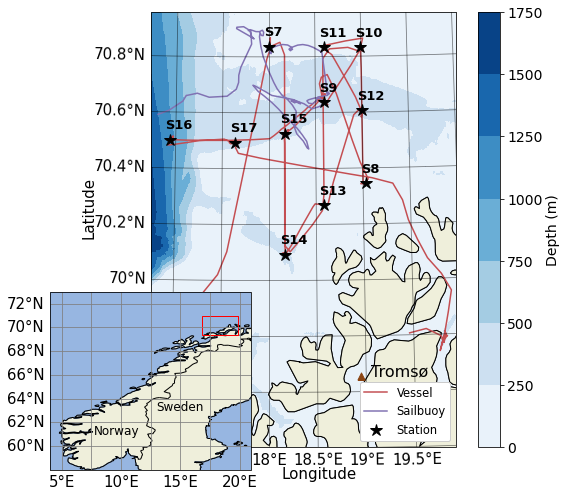

In [108]:
fig   = plt.figure(figsize=(8,8))
#ax    = plt.axes(projection = ccrs.PlateCarree())
proj = ccrs.Orthographic(central_longitude = 18, central_latitude = 70)
ax    = plt.axes(projection = proj)
# Pick the area of interest. In our case, roughly Tromsø
# -- Get hold of the coastlines for that area.
#extent=[15.80, 19.65, 68, 72.20]
extent=[16.8, 19.9, 69.4, 70.95]
ax.set_extent(extent, crs = ccrs.PlateCarree())


#geoms = list(dataset.intersecting_geometries(extent))

X, Y, Z_mask = sb_tools.load_bathy(fname_topo)
Z_mask = np.ma.masked_greater(Z_mask,1700)
im = ax.contourf(X,Y,Z_mask,transform=ccrs.PlateCarree(), cmap=plt.get_cmap('Blues'))
cbar = plt.colorbar(im)
cbar.ax.set_ylabel('Depth (m)', fontsize=14)
ax.set_ylabel('Latitude')

# Add the Stamen aerial imagery at zoom level 7.
tiler = Stamen('terrain-background')
#tiler = GoogleTiles(style = 'satellite')
#ax.add_image(tiler, 8)

gl = ax.gridlines(color='k', alpha=0.5, draw_labels = True)
gl.top_labels = False
gl.right_labels = False

tromso_lon = 18.94956970204
tromso_lat = 69.655891006
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                    edgecolor='black',
                                    facecolor=cfeature.COLORS['land'])
# create map
#ax = plt.subplot(1,1,1,projection=proj)
#ax.gridlines(draw_labels=True)
#ax.set_extent(extent, crs=proj)

ax.coastlines(resolution='10m')
ax.add_feature(land_10m)

dates = []

# Plot track up to time index
plt.plot(SP_position['Longitude'],
         SP_position['Latitude'],
         color=sns.color_palette("deep")[3], 
         label='Vessel',
         transform=ccrs.PlateCarree())
#plt.plot(SP_position['Longitude'],SP_position['Latitude'], 'o',color='green', markersize=4,transform=ccrs.PlateCarree())

plt.plot(SB_position['longitude (deg)'][~np.isnan(SB_position['latitude (deg)'])],
         SB_position['latitude (deg)'][~np.isnan(SB_position['longitude (deg)'])],
         color=sns.color_palette("deep")[4], 
         label='Sailbuoy',
         transform=ccrs.PlateCarree())

# Add stations
plt.plot(SP_lons[6:], 
         SP_lats[6:], 
         'k*', 
         label='Station', 
         markersize=12,
         transform=ccrs.PlateCarree())

# Add station number
for num in range(6,len(stn_num)):
    plt.text(SP_lons[num]-0.05, 
             SP_lats[num]+0.04, 
             'S' + str(stn_num[num]), 
             fontsize=13,
             weight='bold',
             transform=ccrs.PlateCarree())

#plt.plot(SB_position['longitude (deg)'],SB_position['latitude (deg)'], 'o',color='blue', markersize=4,transform=ccrs.PlateCarree())
plt.scatter(tromso_lon, tromso_lat, c = 'saddlebrown', marker = '^', transform=ccrs.PlateCarree(), s = 50,  zorder = 10)
plt.text(tromso_lon+0.1, tromso_lat, 'Tromsø', transform=ccrs.PlateCarree(), fontsize=16, color = 'k')
plt.legend(loc='lower right', fontsize=11.5, framealpha=1)

# Add axes labels
ax.text(-0.18, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=15)
ax.text(0.55, -0.08, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=15)
ax.tick_params(labelsize=14)


# Create an inset GeoAxes showing the location.
#sub_ax = fig.add_axes([0.1, 0.05, 0.3, 0.3],
#                     projection = ccrs.Orthographic(central_longitude = 17, central_latitude = 70))
sub_ax = fig.add_axes([0.04, -0.01, 0.35, 0.5],
                    projection = ccrs.PlateCarree())
sub_ax.set_extent([4, 21, 58, 73])


#fig = plt.figure(figsize=(15,10))
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                    edgecolor='black',
                                    facecolor=cfeature.COLORS['land'])
ocean_50m = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                                    edgecolor='face',
                                    facecolor=cfeature.COLORS['water'])
# Make a nice border around the inset axes.
effect = Stroke(linewidth=4, foreground='wheat', alpha=0.5)
#sub_ax.spines['geo'].set_path_effects([effect])

# Add the land, coastlines and the extent of domain.
sub_ax.add_feature(land_50m)
sub_ax.add_feature(ocean_50m)
sub_ax.coastlines(resolution='50m')
sub_ax.add_feature(cfeature.BORDERS)

sub_ax.text(7.7, 61, 'Norway', transform=ccrs.PlateCarree(), fontsize=12, color = 'k')
sub_ax.text(13, 63, 'Sweden', transform=ccrs.PlateCarree(), fontsize=12, color = 'k')

extent_box = sgeom.box(extent[0], extent[2], extent[1], extent[3])
sub_ax.add_geometries([extent_box], ccrs.PlateCarree(), facecolor='none',
                      edgecolor='red', linewidth=1)
gl_sub = sub_ax.gridlines(color='grey', draw_labels=True)
gl_sub.top_labels  = False
gl_sub.left_labels = True
gl_sub.right_labels = False

ax.set_rasterized(True)
sub_ax.set_rasterized(True)


fig.savefig('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/CJFAS_manuscript/Figs/Figure1.jpg', format='jpg', dpi = 300, facecolor='w', bbox_inches='tight')

In [110]:
SP_stations_df

,Datetime,Station,latitude (deg),longitude (deg),Bottom Depth
0,2018-06-17 11:02:00,1,68.780,14.114,122
1,2018-06-18 10:38:00,2,69.349,13.171,2755
2,2018-06-18 23:41:00,3,68.917,14.402,268
3,2018-06-19 07:07:00,4,69.075,13.953,518
4,2018-06-19 20:53:00,5,69.207,12.965,2750
5,2018-06-20 06:20:00,6,69.119,13.513,1569
6,2018-06-21 03:53:00,7,70.836,17.996,170
7,2018-06-22 03:48:00,8,70.345,19.028,172
8,2018-06-22 17:15:00,9,70.636,18.595,371
9,2018-06-23 01:01:00,10,70.831,18.988,224
